In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report

## Data preparation

### global variable

In [2]:
NUM_TRAIN_IMAGES = 938
NUM_TEST_IMAGES = 196

TRAIN_PATH = 'data/clean-dirty-garbage-containers/train/'
TEST_PATH = 'data/clean-dirty-garbage-containers/test/'

BATCH_SIZE = 64

### Creating a photo generator from the files

In [3]:
# create a data generator
datagen = ImageDataGenerator()

# load and iterate training dataset
train_it = datagen.flow_from_directory(TRAIN_PATH, class_mode='binary', batch_size=BATCH_SIZE)

# load and iterate test dataset
test_it = datagen.flow_from_directory(TEST_PATH, class_mode='binary', batch_size=BATCH_SIZE)

Found 938 images belonging to 2 classes.
Found 196 images belonging to 2 classes.


In [4]:
def plot_clean_and_dirty_photos(iterator, num_pictures=3):
    """
    plot clean and dirty cans from the train labeled data
    the number of pictures will define how much to present in the 
    same time in a matter of rows
    """
    photos, labels = next(iterator)
    clean_id = np.where(labels == 0)[0][:num_pictures]
    dirty_id = np.where(labels == 1)[0][:num_pictures]
    
    fig, ax = plt.subplots(num_pictures, 2, figsize=(12, num_pictures * 3))
    
    for row in range(num_pictures):
        ax[row][0].imshow(photos[clean_id[row]].astype("int"))
        ax[row][0].set_title("clean")

        ax[row][1].imshow(photos[dirty_id[row]].astype("int"))
        ax[row][1].set_title("dirty")
    
    plt.tight_layout()
    plt.show()

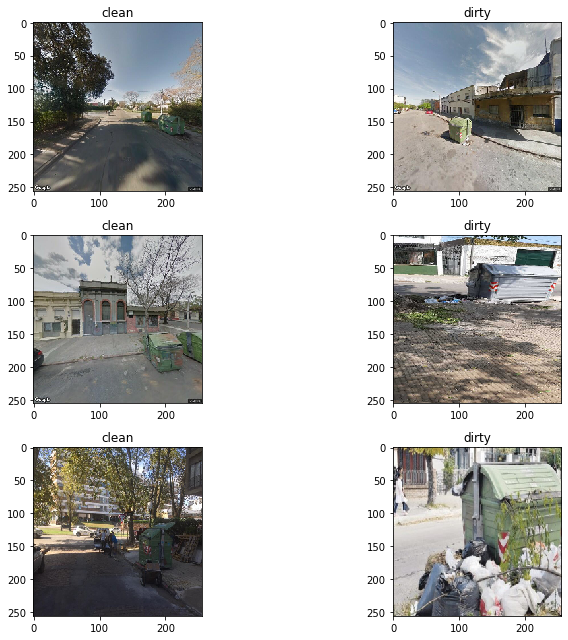

In [5]:
plot_clean_and_dirty_photos(train_it, 3)

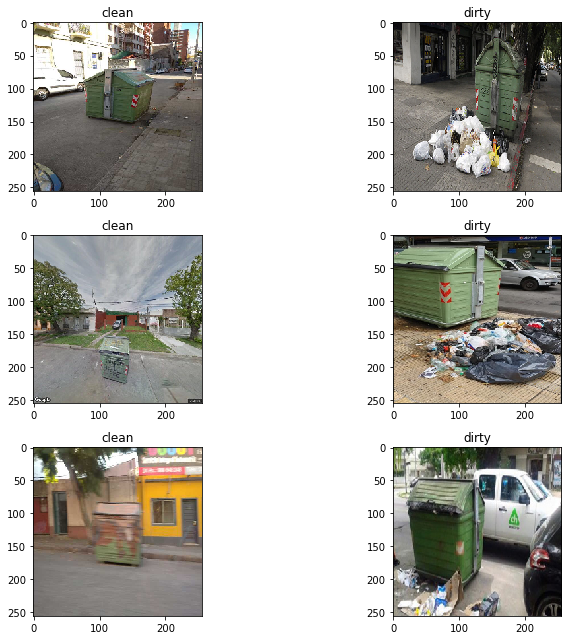

In [6]:
plot_clean_and_dirty_photos(test_it, num_pictures=3)

## Image classification models

### auxiliary function

In [7]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [17]:
def callbacks(model):
    mc = tf.keras.callbacks.ModelCheckpoint(f'{model.name}.h5',
                                         monitor="val_accuracy",
                                         verbose=1,
                                         save_best_only=True,
                                         save_weights_only=False,
                                         ) 
    earlystop = EarlyStopping(patience=3)
    return mc, earlystop

In [18]:
def plot_loss(history):
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].plot(history.history['loss'], color='b', label="Training loss")
    ax[0].plot(history.history['val_loss'], color='r', label="validation loss")
    ax[0].set_title("Loss over epoches")
    legend = ax[0].legend(loc='best', shadow=True)
    
    ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
    ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
    ax[1].set_title("accuracy over epoches")
    ax[1].grid()

    plt.tight_layout()
    plt.show()

###  transfer learning

In [19]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [20]:
resnet_model = Sequential(name="transfer_learning_model")
resnet_model.add(ResNet50(include_top=False, weights="imagenet", pooling='avg'))
resnet_model.add(Dense(1, activation="sigmoid"))

# Say not to train first layer (ResNet) model. It is already trained
resnet_model.layers[0].trainable = False

In [21]:
resnet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.1)

regenerate the iterator for the model - with the pre-process of `imagenet`

In [23]:
train_it = data_generator.flow_from_directory(TRAIN_PATH, class_mode='binary', batch_size=BATCH_SIZE)

valid_it = data_generator.flow_from_directory(TEST_PATH, class_mode='binary', batch_size=BATCH_SIZE, subset='training')
test_it = data_generator.flow_from_directory(TEST_PATH, class_mode='binary', batch_size=BATCH_SIZE, subset='validation')

Found 938 images belonging to 2 classes.
Found 177 images belonging to 2 classes.
Found 19 images belonging to 2 classes.


In [24]:
resnet_model.summary()

Model: "transfer_learning_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________


In [25]:
mc, earlystop = callbacks(resnet_model)
epochs = 20

history_resnet = resnet_model.fit_generator(
                                train_it,
                                steps_per_epoch = train_it.samples//BATCH_SIZE,
                                epochs=epochs,
                                validation_data=valid_it,
                                validation_steps=valid_it.samples // BATCH_SIZE,
                                callbacks=[mc, earlystop])

Epoch 1/20
14/14 [==============================] - ETA: 0s - loss: 0.6448 - accuracy: 0.6465
Epoch 00001: val_accuracy improved from -inf to 0.89062, saving model to transfer_learning_model.h5
14/14 [==============================] - 44s 3s/step - loss: 0.6448 - accuracy: 0.6465 - val_loss: 0.4263 - val_accuracy: 0.8906
Epoch 2/20
14/14 [==============================] - ETA: 0s - loss: 0.5035 - accuracy: 0.7632
Epoch 00002: val_accuracy improved from 0.89062 to 0.92188, saving model to transfer_learning_model.h5
14/14 [==============================] - 45s 3s/step - loss: 0.5035 - accuracy: 0.7632 - val_loss: 0.2889 - val_accuracy: 0.9219
Epoch 3/20
14/14 [==============================] - ETA: 0s - loss: 0.4529 - accuracy: 0.7998
Epoch 00003: val_accuracy did not improve from 0.92188
14/14 [==============================] - 47s 3s/step - loss: 0.4529 - accuracy: 0.7998 - val_loss: 0.2707 - val_accuracy: 0.9219
Epoch 4/20
14/14 [==============================] - ETA: 0s - loss: 0.418

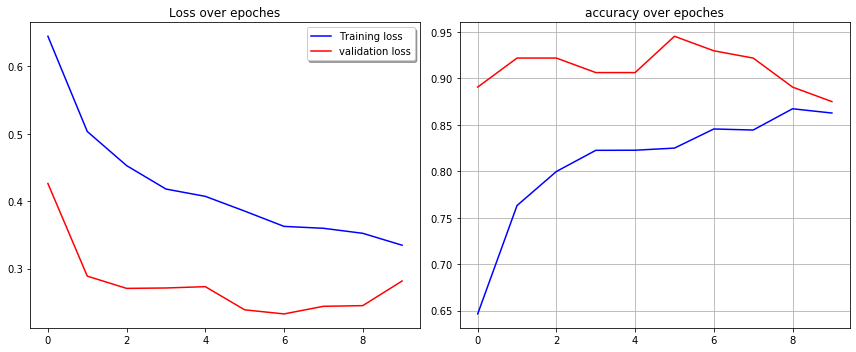

In [26]:
plot_loss(history_resnet)

In [30]:
final_model = tf.keras.models.load_model(f"{resnet_model.name}.h5")

In [31]:
photos, labels = next(test_it)
predictions = final_model.predict(photos).round()
print(classification_report(labels, predictions.round()))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        10
         1.0       1.00      1.00      1.00         9

    accuracy                           1.00        19
   macro avg       1.00      1.00      1.00        19
weighted avg       1.00      1.00      1.00        19



In [32]:
def plot_photos_with_predictions(photos, labels, predictions):
    """

    """
    clean_id = np.where(labels == 0)[0]
    dirty_id = np.where(labels == 1)[0]
    
    num_rows = min(len(clean_id), len(dirty_id))
    
    fig, ax = plt.subplots(num_rows, 2, figsize=(14, num_rows * 4))
    
    for row in range(num_rows):
        ax[row][0].imshow(photos[clean_id[row]].astype("int"))
        ax[row][0].set_title(f"clean - prediction {predictions[clean_id[row]]}")

        ax[row][1].imshow(photos[dirty_id[row]].astype("int"))
        ax[row][1].set_title(f"dirty - prediction {predictions[dirty_id[row]]}")
    
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

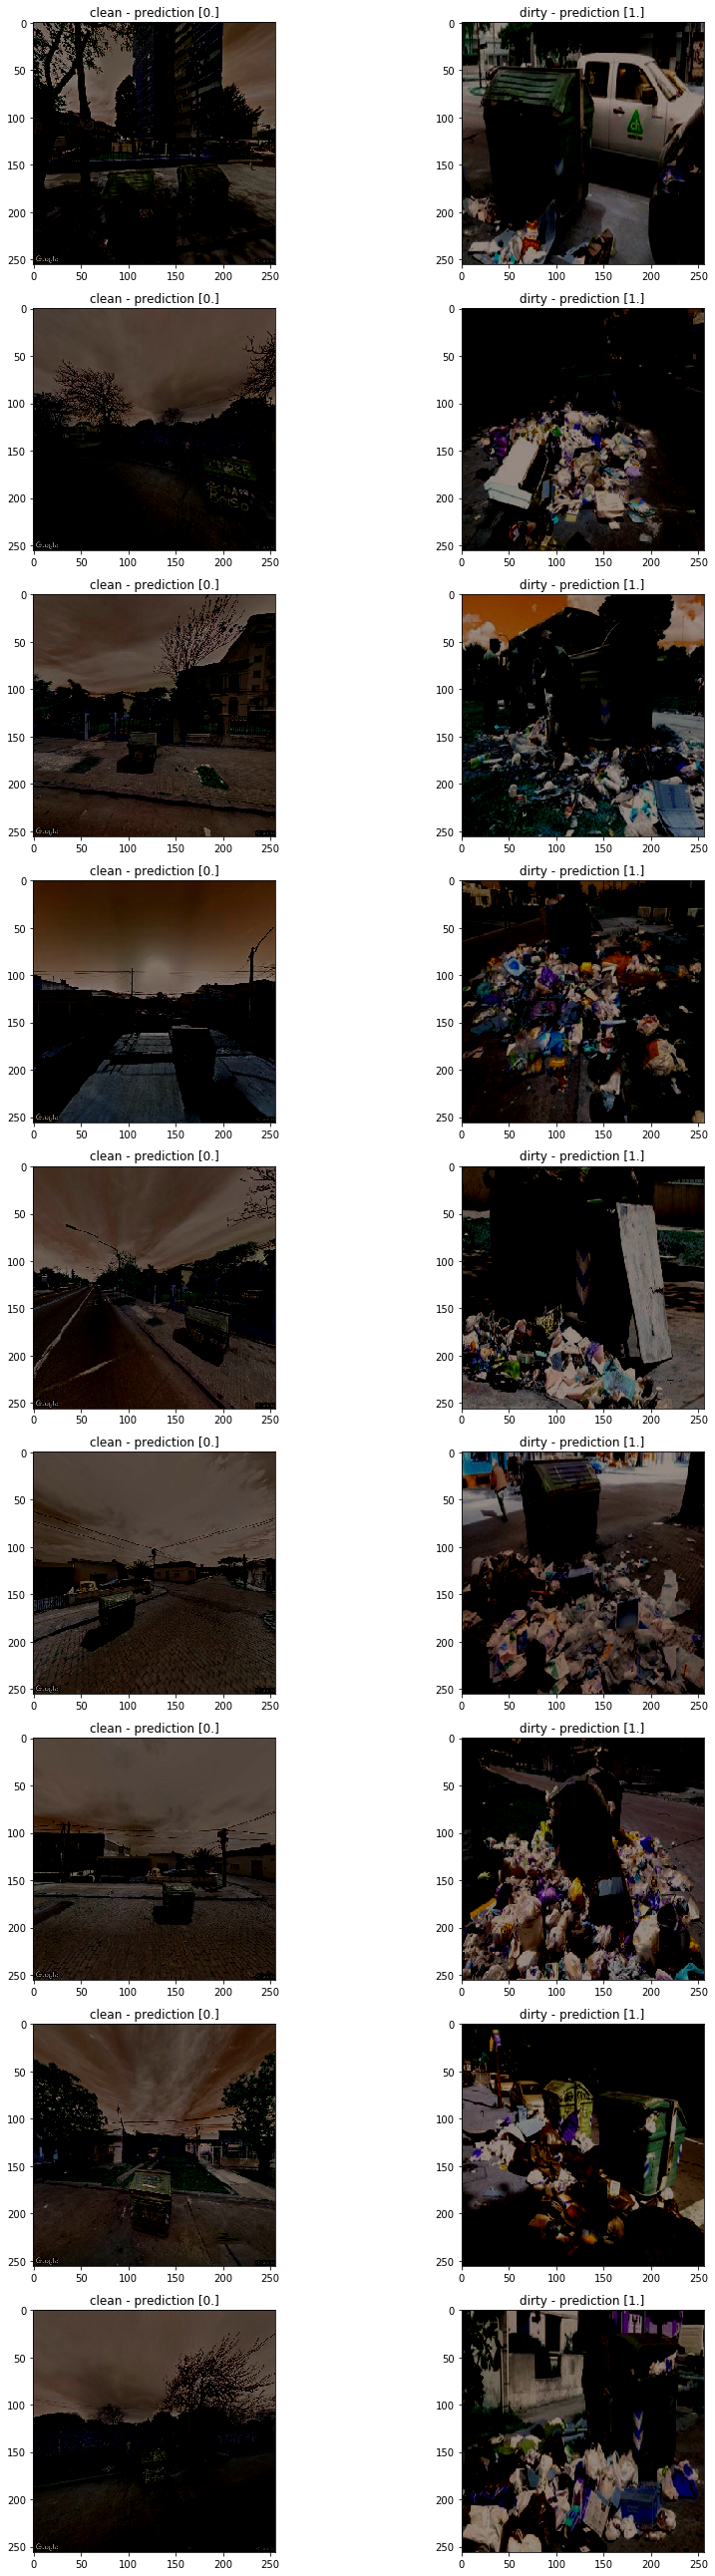

In [33]:
plot_photos_with_predictions(photos, labels, predictions)